# LLM experiments for sentiment analysis

## Import required packages

In [62]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
# Import generic wrappers
from transformers import AutoTokenizer, AutoModelForSequenceClassification 


## Load Abels english dataset and test permormance

In [51]:
data = pd.read_csv('LLM_examples.csv', sep=';')

In [52]:
data.head()

,Sentence,Sentiment
0,I absolutely loved the new movie; it was fanta...,Positive
1,The customer service was excellent; they were ...,Positive
2,This is the best product I've ever used; highl...,Positive
3,I’m so happy with my recent purchase; it excee...,Positive
4,The event was incredibly well-organized and en...,Positive


## Test performance of task specific models

In [53]:
# Define the model repo
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" 


# Download pytorch model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/CA39WS/Repositories/llm-experiments/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be

In [54]:
def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))


In [55]:
data['Predicted_sentiment'] = data['Sentence'].apply(lambda x: sentiment_score(x[:512]))

In [56]:
sentiment_score('good')


2

In [57]:
data

,Sentence,Sentiment,Predicted_sentiment
0,I absolutely loved the new movie; it was fanta...,Positive,2
1,The customer service was excellent; they were ...,Positive,2
2,This is the best product I've ever used; highl...,Positive,2
3,I’m so happy with my recent purchase; it excee...,Positive,2
4,The event was incredibly well-organized and en...,Positive,2
...,...,...,...
1015,Watched a few episodes of a show I’m catching ...,Neutral,2
1016,"The mail today was mostly bills, just the usual.",Neutral,1
1017,"Went for a walk around the neighborhood, it wa...",Neutral,2
1018,"Did a load of laundry this morning, just part ...",Neutral,1


In [58]:
data['Sentiment'] = data['Sentiment'].apply(lambda x: 2 if x == 'Positive' else 0 if x == 'Negative' else 1)
data.head()

,Sentence,Sentiment,Predicted_sentiment
0,I absolutely loved the new movie; it was fanta...,2,2
1,The customer service was excellent; they were ...,2,2
2,This is the best product I've ever used; highl...,2,2
3,I’m so happy with my recent purchase; it excee...,2,2
4,The event was incredibly well-organized and en...,2,2


In [59]:
#chech performance
from sklearn import metrics

# define confusion matrix
confusion_matrix = metrics.confusion_matrix(data['Sentiment'], data['Predicted_sentiment'])

print(confusion_matrix)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[[335   3   2]
 [ 19 157 164]
 [  0   0 340]]


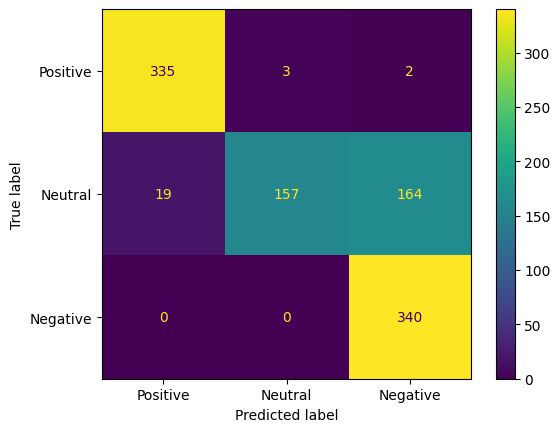

In [63]:
# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Positive", "Neutral", "Negative"])

# display matrix
cm_display.plot()
plt.show()